In [1]:
!pip install catboost > None

In [2]:
!pip install shap > None

In [3]:
import shap

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [5]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

In [6]:
from catboost import CatBoostRegressor

In [7]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [8]:
from sklearn.metrics import make_scorer #для создания авторских метрик
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
df = pd.read_csv('/content/Distr_data_0202.csv')

In [11]:
category_list = ['Spehricity', 'Crystalline', 'Space group']
for i in category_list:
  df[i] = df[i].astype('category')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Area/volume                    542 non-null    float64 
 1   Max/min                        542 non-null    float64 
 2   org_coating_HAcceptors         542 non-null    float64 
 3   org_coating_LogP               542 non-null    float64 
 4   common_spin                    542 non-null    float64 
 5   Eff_anisotropy_const           542 non-null    float64 
 6   Magnetic_anisotropy            542 non-null    float64 
 7   Magnetocrystalline_anisotropy  542 non-null    float64 
 8   Anisotropy constant            542 non-null    float64 
 9   Crystalline                    542 non-null    category
 10  MAE                            542 non-null    float64 
 11  Curie_temperature              542 non-null    float64 
 12  Spehricity                     542 n

# Модели и сравнение

In [13]:
X = df.drop('Remanence_magnetization', axis=1)  #Без целевой переменной
y = df['Remanence_magnetization']  #Целевая переменная

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Модели
models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    RandomForestRegressor(n_estimators=100, random_state=42),
    GradientBoostingRegressor(n_estimators=100, random_state=42),
    AdaBoostRegressor(n_estimators=100, random_state=42),
    BaggingRegressor(n_estimators=100, random_state=42),
    SVR(),
    KNeighborsRegressor(),
    MLPRegressor(max_iter=500)]

In [16]:
# Сохраняем результаты в список
results = []

# Нужно оценить каждую модель
for model in models:
    model.fit(X_train, y_train)  # Указываем категориальный признак
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': model.__class__.__name__,
        'MSE': mse,
        'RMSE': np.sqrt(mse),
        'R2': r2
    })

In [17]:
df_results = pd.DataFrame(results)
print(df_results)

                        Model       MSE      RMSE        R2
0            LinearRegression  0.005495  0.074129  0.474333
1                       Ridge  0.005472  0.073971  0.476574
2                       Lasso  0.010488  0.102410 -0.003272
3                  ElasticNet  0.010488  0.102410 -0.003272
4       RandomForestRegressor  0.000819  0.028613  0.921683
5   GradientBoostingRegressor  0.001274  0.035688  0.878160
6           AdaBoostRegressor  0.002418  0.049175  0.768677
7            BaggingRegressor  0.000794  0.028178  0.924047
8                         SVR  0.008130  0.090164  0.222316
9         KNeighborsRegressor  0.011753  0.108409 -0.124266
10               MLPRegressor  0.007206  0.084888  0.310668


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


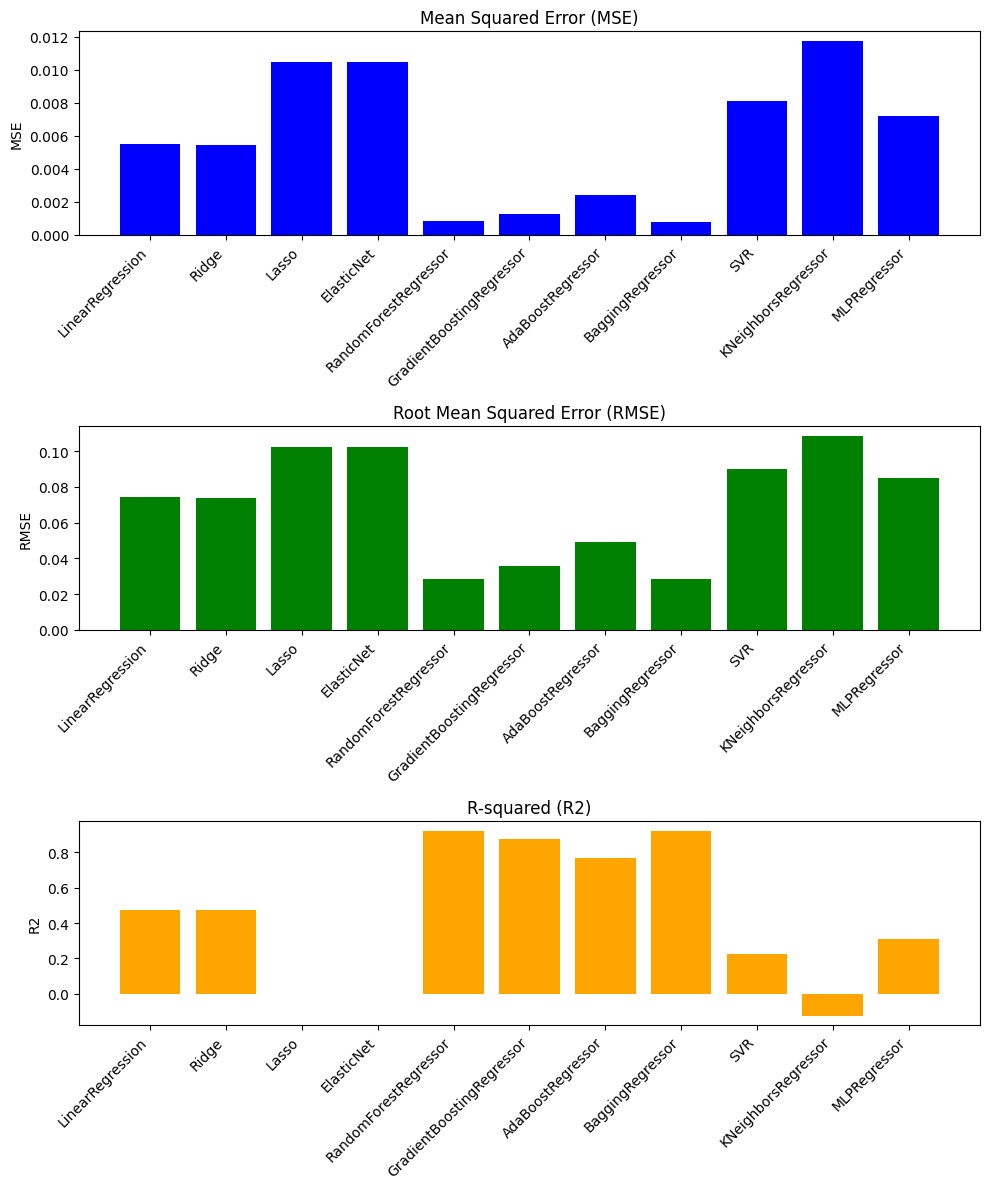

In [18]:
# Создаем фигуру и оси для графиков
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# График среднеквадратичной ошибки (MSE)
ax1.bar(df_results['Model'], df_results['MSE'], color='blue')
ax1.set_title('Mean Squared Error (MSE)')
ax1.set_ylabel('MSE')
ax1.set_xticklabels(df_results['Model'], rotation=45, ha='right')

# График корня из среднеквадратичной ошибки (RMSE)
ax2.bar(df_results['Model'], df_results['RMSE'], color='green')
ax2.set_title('Root Mean Squared Error (RMSE)')
ax2.set_ylabel('RMSE')
ax2.set_xticklabels(df_results['Model'], rotation=45, ha='right')

# График коэффициента детерминации (R2)
ax3.bar(df_results['Model'], df_results['R2'], color='orange')
ax3.set_title('R-squared (R2)')
ax3.set_ylabel('R2')
ax3.set_xticklabels(df_results['Model'], rotation=45, ha='right')

# Регулируем расположение графиков
plt.tight_layout()

# Показываем графики
plt.show()

# Кроссвалидация RandomForest

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Создаем объект RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Выполняем кросс-валидацию
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Преобразуем отрицательные значения MSE в положительные
cv_rmse_scores = np.sqrt(-cv_scores)

# Выводим результаты кросс-валидации
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", np.mean(cv_rmse_scores))

Cross-Validation RMSE Scores: [0.01829497 0.03871463 0.01995422 0.01946899 0.02817625 0.02428665
 0.04204886 0.00744568 0.02305526 0.02835916]
Mean RMSE: 0.024980467836266028


In [20]:
from sklearn.model_selection import GridSearchCV

# Определяем пространство поиска гиперпараметров
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Создаем объект RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Создаем объект GridSearchCV
grid_search = GridSearchCV(rf_model, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# Выполняем поиск по сетке
grid_search.fit(X_train, y_train)

# Выводим оптимальные гиперпараметры
print("Best Parameters:", grid_search.best_params_)

# Получаем лучшую модель
best_rf_model = grid_search.best_estimator_

# Пересчитываем кросс-валидацию с использованием лучших параметров
cv_scores_optimized = cross_val_score(best_rf_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Преобразуем отрицательные значения MSE в положительные
cv_rmse_scores_optimized = np.sqrt(-cv_scores_optimized)

# Выводим результаты кросс-валидации до и после оптимизации
print("\nBefore Optimization:")
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", np.mean(cv_rmse_scores))

print("\nAfter Optimization:")
print("Cross-Validation RMSE Scores:", cv_rmse_scores_optimized)
print("Mean RMSE:", np.mean(cv_rmse_scores_optimized))

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Before Optimization:
Cross-Validation RMSE Scores: [0.01829497 0.03871463 0.01995422 0.01946899 0.02817625 0.02428665
 0.04204886 0.00744568 0.02305526 0.02835916]
Mean RMSE: 0.024980467836266028

After Optimization:
Cross-Validation RMSE Scores: [0.01797812 0.03828726 0.02030424 0.0186049  0.02724442 0.02339518
 0.04249501 0.00799921 0.02207919 0.02723463]
Mean RMSE: 0.02456221719502183


In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Создаем объект RandomForestRegressor с оптимальными гиперпараметрами
best_rf_model = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_leaf=1, min_samples_split=2, random_state=42)

# Выполняем кросс-валидацию
cv_scores_optimized = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Преобразуем отрицательные значения MSE в положительные
cv_rmse_scores_optimized = np.sqrt(-cv_scores_optimized)

# Выводим результаты кросс-валидации до и после оптимизации
print("\nBefore Optimization:")
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", np.mean(cv_rmse_scores))

print("\nAfter Optimization:")
print("Cross-Validation RMSE Scores:", cv_rmse_scores_optimized)
print("Mean RMSE:", np.mean(cv_rmse_scores_optimized))


Before Optimization:
Cross-Validation RMSE Scores: [0.01829497 0.03871463 0.01995422 0.01946899 0.02817625 0.02428665
 0.04204886 0.00744568 0.02305526 0.02835916]
Mean RMSE: 0.024980467836266028

After Optimization:
Cross-Validation RMSE Scores: [0.03197419 0.02161322 0.0250139  0.03094937 0.0268282 ]
Mean RMSE: 0.02727577474272901


In [22]:
# Обучаем оптимизированную модель
best_rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42)

In [23]:
# Assuming you have an optimized RandomForest model named 'best_rf_model'
best_rf_model.fit(X_train, y_train)  # Fit the model on the entire training set

# Making predictions on the training data
y_pred_train_optimized = best_rf_model.predict(X_train)

In [24]:
# Получение предсказаний для тестовой выборки
y_test_pred_optimized = best_rf_model.predict(X_test)

# Расчет метрик для оптимизированной модели
mse_optimized = mean_squared_error(y_test, y_test_pred_optimized)
rmse_optimized = np.sqrt(mse_optimized)
r2_optimized = r2_score(y_test, y_test_pred_optimized)

## Визуализации предсказаний RandomForest


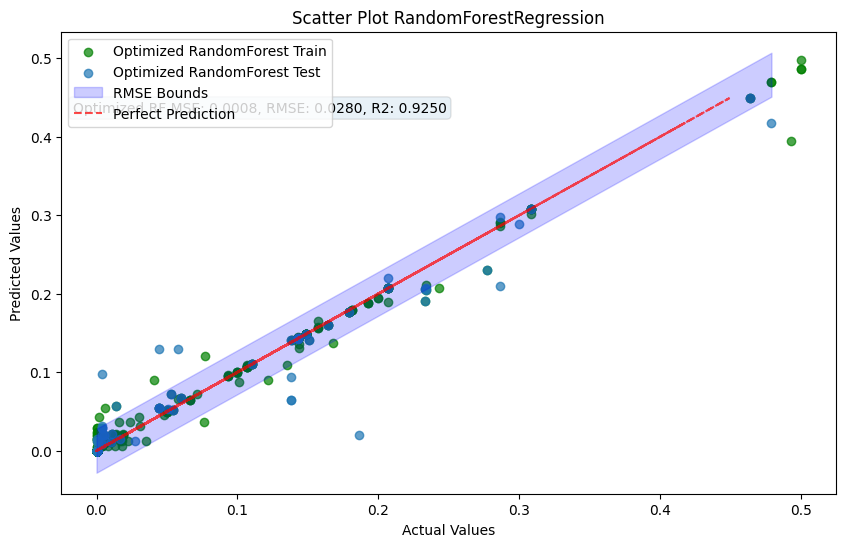

In [25]:
plt.figure(figsize=(10, 6))

# Scatter plot for training data
plt.scatter(y_train, y_pred_train_optimized, label='Optimized RandomForest Train', alpha=0.7, color='green')

# Scatter plot for test data
plt.scatter(y_test, y_test_pred_optimized, label='Optimized RandomForest Test', alpha=0.7)

# Scatter plot for test data with RMSE bounds
lower_bound_rf = np.sort(y_test - rmse_optimized)
upper_bound_rf = np.sort(y_test + rmse_optimized)
plt.fill_between(np.sort(y_test), lower_bound_rf, upper_bound_rf, color='blue', alpha=0.2, label='RMSE Bounds')

# Ideal prediction line
plt.plot(y_test_pred_optimized, y_test_pred_optimized, label='Perfect Prediction', linestyle='--', color='red', alpha=0.7)

# Text with metrics in the upper-left corner of the plot
text_optimized = f'Optimized RF MSE: {mse_optimized:.4f}, RMSE: {rmse_optimized:.4f}, R2: {r2_optimized:.4f}'
plt.text(0.015, 0.85, text_optimized, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

# Display the plot
plt.title('Scatter Plot RandomForestRegression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Кроссвалидация Bagging

In [26]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Создаем базовую модель (например, DecisionTreeRegressor)
base_model = DecisionTreeRegressor()

# Создаем объект BaggingRegressor
bagging_model = BaggingRegressor(base_model, n_estimators=100, random_state=42)

# Выполняем кросс-валидацию
cv_scores = cross_val_score(bagging_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Преобразуем отрицательные значения MSE в положительные
cv_rmse_scores = np.sqrt(-cv_scores)

# Выводим результаты кросс-валидации
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", np.mean(cv_rmse_scores))

Cross-Validation RMSE Scores: [0.01801956 0.03919312 0.02049654 0.02007565 0.02835817 0.02350626
 0.039005   0.00799019 0.02202868 0.02750784]
Mean RMSE: 0.02461810198808023


In [27]:
from sklearn.model_selection import GridSearchCV

# Определяем пространство поиска гиперпараметров
param_grid = {
    'n_estimators': [50, 100, 200],
    'base_estimator__max_depth': [None, 10, 20],
    'base_estimator__min_samples_split': [2, 5, 10],
    'base_estimator__min_samples_leaf': [1, 2, 4]
}

# Создаем базовую модель (DecisionTreeRegressor)
base_model = DecisionTreeRegressor()

# Создаем объект BaggingRegressor
bagging_model = BaggingRegressor(base_model, random_state=42)

# Создаем объект GridSearchCV
grid_search = GridSearchCV(bagging_model, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# Выполняем поиск по сетке
grid_search.fit(X_train, y_train)

# Выводим оптимальные гиперпараметры
print("Best Parameters:", grid_search.best_params_)

# Получаем лучшую модель
best_bagging_model = grid_search.best_estimator_

# Пересчитываем кросс-валидацию с использованием лучших параметров
cv_scores_optimized = cross_val_score(best_bagging_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Преобразуем отрицательные значения MSE в положительные
cv_rmse_scores_optimized = np.sqrt(-cv_scores_optimized)

# Выводим результаты кросс-валидации до и после оптимизации
print("\nBefore Optimization:")
print("Cross-Validation RMSE Scores:", cv_rmse_scores)
print("Mean RMSE:", np.mean(cv_rmse_scores))

print("\nAfter Optimization:")
print("Cross-Validation RMSE Scores:", cv_rmse_scores_optimized)
print("Mean RMSE:", np.mean(cv_rmse_scores_optimized))

Parameter 'base_estimator' of BaggingRegressor is deprecated in favor of 'estimator'. See BaggingRegressor's docstring for more details.


Best Parameters: {'base_estimator__max_depth': None, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'n_estimators': 200}

Before Optimization:
Cross-Validation RMSE Scores: [0.01801956 0.03919312 0.02049654 0.02007565 0.02835817 0.02350626
 0.039005   0.00799019 0.02202868 0.02750784]
Mean RMSE: 0.02461810198808023

After Optimization:
Cross-Validation RMSE Scores: [0.01877809 0.03787599 0.02031325 0.01882086 0.02726445 0.02281838
 0.04118444 0.00832279 0.02119508 0.02647535]
Mean RMSE: 0.024304867198721887


In [28]:
# Обучаем оптимизированную модель
best_bagging_model.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=200,
                 random_state=42)

In [29]:
best_bagging_model.fit(X_train, y_train)  # Fit the model on the entire training set

# Making predictions on the training data
y_pred_train_optimized_bag = best_bagging_model.predict(X_train)

In [30]:
# Получение предсказаний для тестовой выборки
y_test_pred_optimized_bag = best_bagging_model.predict(X_test)

# Расчет метрик для оптимизированной модели
mse_optimized_bag = mean_squared_error(y_test, y_test_pred_optimized_bag)
rmse_optimized_bag = np.sqrt(mse_optimized)
r2_optimized_bag = r2_score(y_test, y_test_pred_optimized_bag)

## Визуализации предсказаний Bagging

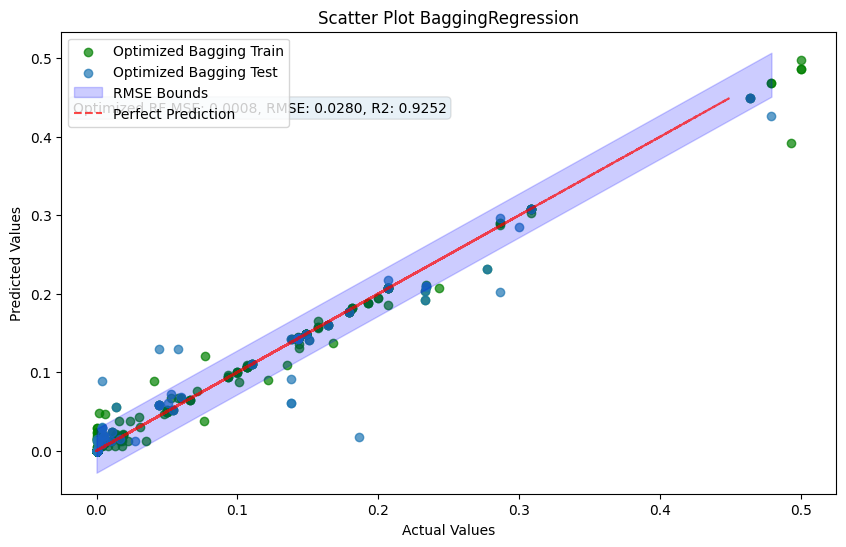

In [31]:
plt.figure(figsize=(10, 6))

# Scatter plot for training data
plt.scatter(y_train, y_pred_train_optimized_bag, label='Optimized Bagging Train', alpha=0.7, color='green')

# Scatter plot for test data
plt.scatter(y_test, y_test_pred_optimized_bag, label='Optimized Bagging Test', alpha=0.7)

# Scatter plot for test data with RMSE bounds
lower_bound_rf = np.sort(y_test - rmse_optimized_bag)
upper_bound_rf = np.sort(y_test + rmse_optimized_bag)
plt.fill_between(np.sort(y_test), lower_bound_rf, upper_bound_rf, color='blue', alpha=0.2, label='RMSE Bounds')

# Ideal prediction line
plt.plot(y_test_pred_optimized_bag, y_test_pred_optimized_bag, label='Perfect Prediction', linestyle='--', color='red', alpha=0.7)

# Text with metrics in the upper-left corner of the plot
text_optimized = f'Optimized RF MSE: {mse_optimized_bag:.4f}, RMSE: {rmse_optimized_bag:.4f}, R2: {r2_optimized_bag:.4f}'
plt.text(0.015, 0.85, text_optimized, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

# Display the plot
plt.title('Scatter Plot BaggingRegression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Визуализации SHAP

  0%|          | 0/109 [00:00<?, ?it/s]

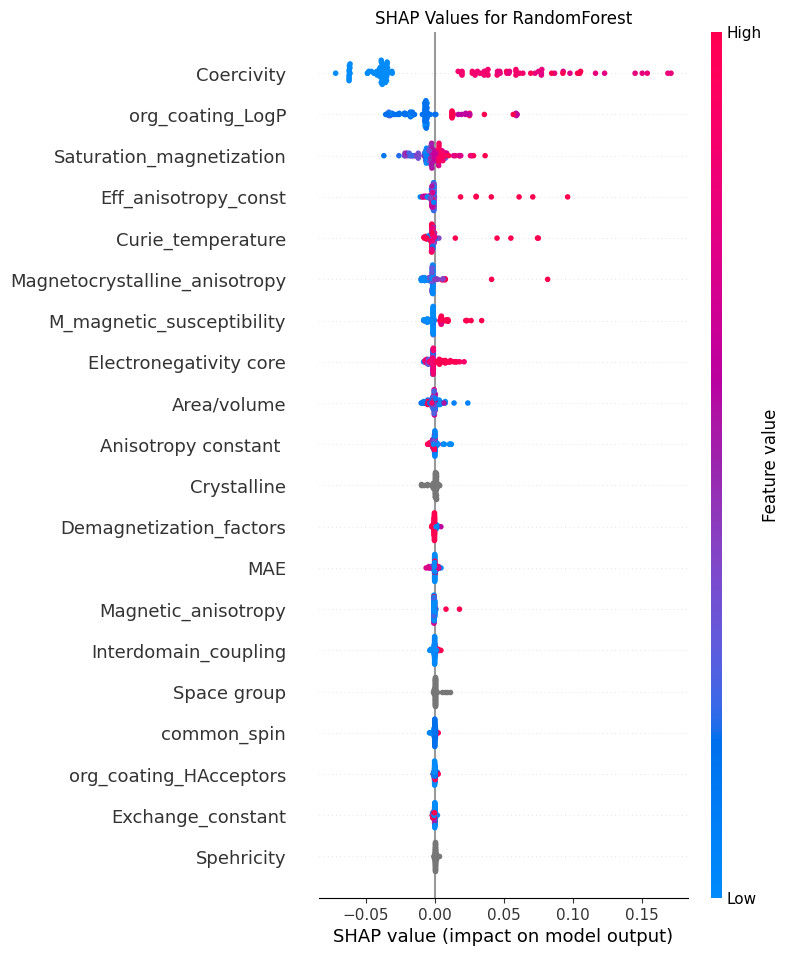

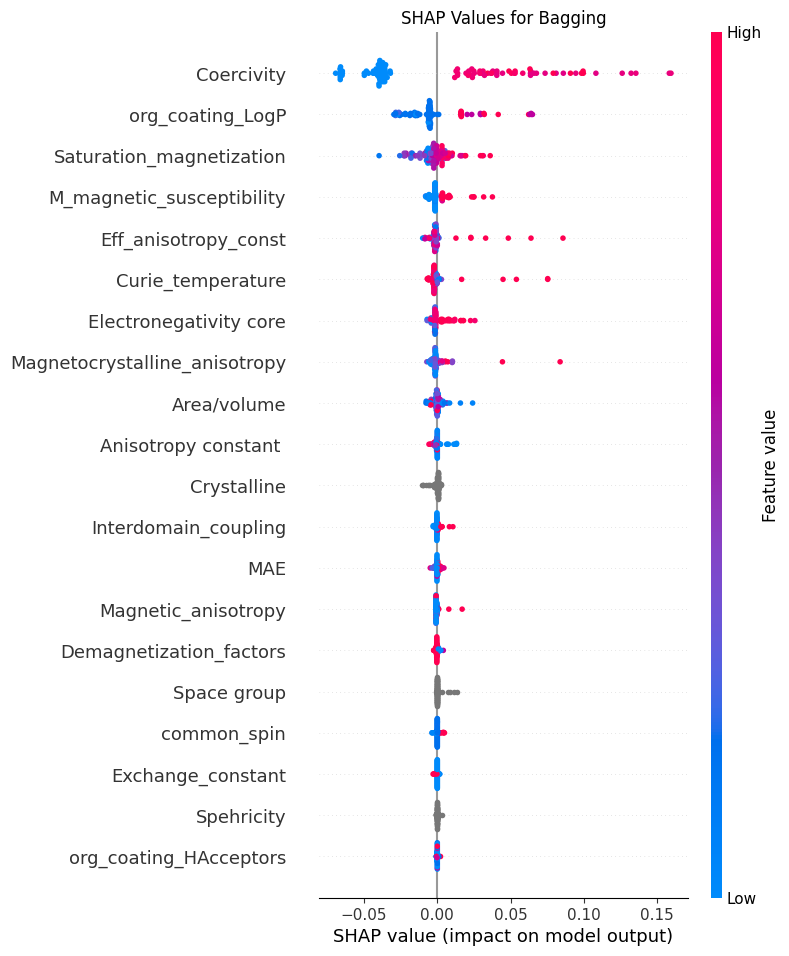

In [34]:
import shap

# Создание explainer'ов
rf_explainer = shap.TreeExplainer(best_rf_model)

# Вместо TreeExplainer для Bagging используем KernelExplainer
bagging_explainer = shap.KernelExplainer(best_bagging_model.predict, X_train)

# Расчет SHAP-значений для тестового набора данных
shap_values_rf = rf_explainer.shap_values(X_test)
shap_values_bagging = bagging_explainer.shap_values(X_test)

# Построение SHAP-диаграммы для RandomForest
shap.summary_plot(shap_values_rf, X_test, feature_names=X_test.columns, show=False)
plt.title('SHAP Values for RandomForest')
plt.show()

# Построение SHAP-диаграммы для Bagging
shap.summary_plot(shap_values_bagging, X_test, feature_names=X_test.columns, show=False)
plt.title('SHAP Values for Bagging')
plt.show()